# 1 Overview

* Developing a strong machine learning model for error mitigation based on two gates SU(4) parameter space.
    - **This method gave ~0.4 fidelity improvement and fidelity reached 0.8239 at trotter steps=10.**
* Trotter step decomposition is the same as the baseline, which is the host provided notebook method.
* Using KAK decomposition for each step and use 3 CNOT on a circuit implementation instead of the 6 CNOT at the baseline


| | |
| --- | --- |
|![result_table.png](images/results_plot.png) | ![overview.png](images/overview.png) |

| Phase |  Item |enhancement from baseline|  description |
| --- | --- | --- |--- |
| Hamiltonian Decomposition | Trotter Decomposition | - | Use baseline method, Dividing Hamiltonian into 1-3, 3-5 interaction terms |
| Hamiltonian Decomposition  | KAK Decomposition | +0.20 | 3 cnot gates instead of the 6 CNOT at baseline |
| Post Process | Measurement Error Mitigation |+0.07| Using qiskit class CompleteMeasFilter |
| Post Process | Trotter step Error Mitigation | +0.4| Using ["XGBoost"(eXtreme Gradient Boosting)](https://github.com/dmlc/xgboost) regressor  |



# Guide in this notebook and my project files

* Description of my approach: [2 My approach](#2-My-approach)
* Final code submition part: [3 Code run](#3-Code-run)
* My project python related file configuration: 
```txt
    │
    ├ README.md                        # for preparing this notebook environment, so before start runing any code please check it.
    ├ submission.ipynb                 # This notebook. My submission notebook for this contest.
    ├ run_circuit.py                   # top level python code for this contest, which is explained at my final code part
    ├ run_error_mitigation_learning.py # error mitigation learning code which is explained at 2 My approach part.
    └ src/                             # source code directory of this contest including config/parameters.
```

**CAUTION**: Before runing code please make sure your IBMQ accout saved in your host. You can check it [this section](#IBMQ-account-setting)

# Table of contents


* [1 Overview](#1-Overview)
    + [Table of contents](#Table-of-contents)
    + [IBMQ account setting](#IBMQ-account-setting)
    + [Basic imports](#Basic-imports)
* [2 My approach](#2-My-approach)
    + [2 1 Hamiltonian and Notation ](#2-1-Hamiltonian-and-Notation-)
    + [2 2 Trotterization](#2-2-Trotterization)
    + [2 3 KAK decomposition](#2-3-KAK-decomposition)
        + [Check 3 CNOT decomposition with the circuit of contest github notebook](#Check-3-CNOT-decomposition-with-the-circuit-of-contest-github-notebook)
    + [2 4 Measurement Error Mitigation](#2-4-Measurement-Error-Mitigation)
    + [2 5 Xgboost(data driven) Error Mitigation](#2-5-Xgboost(data-driven)-Error-Mitigation)
    + [2 5 1 formulation](#2-5-1-formulation)
        + [Why predict 8 dim vector instead of directly 8x8 matrix](#Why-predict-8-dim-vector-instead-of-directly-8x8-matrix)
    + [2 5 2 Data Contents:](#2-5-2-Data-Contents:)
        + [Input features](#Input-features)
        + [Meta feature about input circuit](#Meta-feature-about-input-circuit)
        + [Target/Label data](#Target/Label-data)
        + [How to get/use calibration data from backend](#How-to-get/use-calibration-data-from-backend)
    + [2 5 3 Input Data Generation: Sampling Strategy](#2-5-3-Input-Data-Generation:-Sampling-Strategy)
        + [Check the generated data statistics](#Check-the-generated-data-statistics)
        + [Genereate circuits for several cases](#Genereate-circuits-for-several-cases)
    + [2 5 4 Training](#2-5-4-Training)
        + [collecting csv data, simply loading cached data here](#collecting-csv-data,-simply-loading-cached-data-here)
        + [Start training and saving a model](#Start-training-and-saving-a-model)
    + [Check-the-input-feature-importance](#Check-the-input-feature-importance)
    + [2 5 5 Inference](#2-5-5-Inference)
        + [Loading IBMQ results](#Loading-IBMQ-results)
        + [Comparison w/wo xgb filter](#Comparison-w/wo-xgb-filter)
* [3 Code run](#3-Code-run)
    * [Imports](#Imports)
    * [Config file load  and General settings](#Config-file-load--and-General-settings)
    * [IBMQ/Aer JOB submission](#IBMQ/Aer-JOB-submission)
    * [Job Evaluation](#Job-Evaluation)
    * [Appendix](#Appendix)
    * [Comparison: Other CNOT decomposition](#Comparison:-Other-CNOT-decomposition)


## IBMQ account setting

In [1]:
from getpass import getpass

from qiskit import IBMQ

# replace TOKEN with your API token string
# (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
# IBMQ.save_account("TOKEN", overwrite=True)
try:
    provider = IBMQ.load_account()
except:
    print("Could not find any enabled IBMQ accounts")
    TOKEN = getpass("Enter your IBMQ API token here:")
    IBMQ.save_account(TOKEN, overwrite=True)
    provider = IBMQ.load_account()

print("Current loaded IBMQ provider is ", provider)

Could not find any enabled IBMQ accounts
Enter your IBMQ API token here: ································································································································
Current loaded IBMQ provider is  <AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>


## Basic imports

In [2]:
import copy
import json
import pickle
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from omegaconf import OmegaConf

# 2 My approach

I tried something general frame work for error mitigation under "Trotterization".

One of the most famous error mitigation method is zero noise extrapolation [1], ZNE.
In this method, We assumed a specific quantum circuit and then collecting data with various noise level for
zero noise extrapolation. The collected data and extrapolation model is only valid to the assumed quantum circuit.

Are there any method at which collected data or mitigation model for a specific circuit can be used or transferred to other quantum circuit mitigation?

My approach is adding new circuit parameters axis on error mitigation method like [FIG.1](#FIG.1:comparison_with_ZNE) below.
These added circuit parameters has specific representation, that is, "SU(4) weyl chamber three parameters"[2], ${\bf c} = (\alpha, \beta, \gamma )$ for trotter step.
Because any two gates unitary SU(4) is systematically characterized in weyl chamber[2].
 Unlike ZNE, in this settings, "circuit error = trotter step cumulative error",  $\text{Error}_{\text{tr}}$ is estimated,
$$
\begin{equation}
\text{Error}_{\text{trot}} = Y(n, {\bf c})
\end{equation}
$$
where $Y$ is an error prediction model and $n$ is the number of trotter steps.
My target is finding a procedure for constructing $Y(n, {\bf c})$. But the contest time is limited so during the contest, I set the following limit on my study,
$$
\text{contest search space:}\ Y(n, {\bf c}=\{H_{xxx}\}=(T/n, T/n, T/n)),
$$
where $H_{xxx}$ means contest hamiltonian. Still set this limit, I tried not to introduce a method which breaks generalization for arbitrary $(n, {\bf k})$ pair.

Regarding introducing new axis on ZNE, there is a study[3], multi dimensional extension of ZNE. But at that study target is "target expectation value".

<!-- In ideal situation this $Y$ would be independent from target expectation value.
 -->

|<a id="FIG.1:comparison_with_ZNE"></a>|
| --- |
|![FIG.1:comparison_with_ZNE](images/comparison_with_ZNE.png) |
| **FIG.1: error modeling comparison, zero noise extrapolation(left) and my approach(right).I focused on error derived from each trotter step $U_{t}$ rather than a target expectation value**|

### data collection
Like zero noise extrapolation, we need data collection for an error prediction model $Y$.


Introducing inverse trotter step ${U_{\text{trot}}}^{\dagger}$ for plain/forward trotter step ${U_{\text{trot}}}$ ,
This is inspired by the previous research[4-6], which introduced "inverse ciruit" or "inverse sub circuit" on error mitigation.
Based on these step, I implemented convenient and reliable data collection, [FIG.2](#FIG.2:data_collection). At this data collection, each circuit always implementing identity, which means,
 **the error of each single circuit run is determined exactly with only using its result**. We can easily get error with simple arithmetic,
 $$
  \delta_{ij} - \text{observed counts}_{j}/\text{shots}
 $$
 where $\delta_{ij}$ kronecker delta, $i$ is initial state index, $j$ is observation index. Here, both initial and observed base are selected the same.
 
 There are several benefits,

* data sampling is really easy
* use arbitrary initial state 
* less biased $Y$ can be constructed

Furthermore under trotterization, inverse step is relatively shallow compared to a whole circuit so we can expect more fine grained error can be observed. Because if a whole circuit and its inverse circuit are used, some error is more likely canceled with relatively deep inverse process.

At this this data collection there is a one contraint, that is, trotter steps $n$ must be even. 


|  <a id="FIG.2:data_collection"></a> |
| --- |
|![FIG.2:data_collection](images/data_collection_trotter_step_error.png) |
| **FIG.2: Data collection for trotter steps, $n=2, 4$ cases. When $n > 2$ two kind of circuits were defined for actual data collection**|

As illustrated at [FIG.2](#FIG.2:data_collection) two kind of circuits, "half inverse" and "repeat inverse" are introduced.
This is because let error model $Y$ be less agnostic for trotter step order.

#### Machine Learning Model
* Error model $Y(n, {\bf c})$ should be a complicated function -> I decided to use machine learning model [dlmc "XGBoost"(eXtreme Gradient Boosting)](https://github.com/dmlc/xgboost).

 > XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Kubernetes, Hadoop, SGE, MPI, Dask) and can solve problems beyond billions of examples.



----------------------
**Reference**

\[1\] Temme, K., Bravyi, S. and Gambetta, J. M, *Error mitigation for short-depth quantum circuits*, [Physical Review Letters 119, 180509 (2017)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509)  \[[free arxiv version](https://arxiv.org/abs/1612.02058)\]

\[2\] Jun Zhang, et al., *Geometric theory of nonlocal two-qubit operations* [Physical Review A 67, 042313 (2003)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.67.042313) \[[free arxiv version](https://arxiv.org/abs/quant-ph/0209120)\]

\[3\] Matthew Otten and Stephen K Gray, *Recovering noise-free quantum observables* [Physical Review A 99, 012338](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.012338) \[[free arxiv version](https://arxiv.org/abs/1806.07860)\]

\[4\] Tudor Giurgica-Tiron, et al., *Digital zero noise extrapolation for quantum error mitigation* [DOI:10.1109/QCE49297.2020.00045](https://ieeexplore.ieee.org/document/9259940) \[[free arxiv version](https://arxiv.org/abs/2005.10921)\]

\[5\] T. E. O’Brien, et al., *Error mitigation via verified phase estimation*, [arxiv:2010.02538 \[quant-ph\] (2020)](https://arxiv.org/abs/2010.02538)

\[6\] Mingxia Huo and Ying Li, *Dual-state purification for practical quantum error mitigation*, [Physical Review A 105, 022427
(2001)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.022427) \[[free arxiv version](https://arxiv.org/abs/2105.01239)\]

\[7\] P. Czarnik  et al., *Error mitigation with Clifford quantum-circuit data*, [Quantum 5, 592 (2021)](https://quantum-journal.org/papers/q-2021-11-26-592/)  \[[arxiv version](https://arxiv.org/abs/2005.10189)\]



## 2-1 Hamiltonian and Notation

We follow the notation of the [contest Github notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb)

The target hamiltonian of this competition is
$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N = 3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$
The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrixes) where the $i$ and $j$ superscripts label which qubit they act on.
And corresponding time evolution operator, $U_{\text{Heis3}}(t)$

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left(-it H_\text{Heis3}\right) = \exp\left[-it \sum_{\langle ij \rangle}^{N=3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right]
\end{align}
$$.

## 2-2 Trotterization


Consider a subsystem of 2 spin-1/2 particles within the larger 3 spin system. The Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) would be $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. And then one simple Trotterization is


$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n
\end{align}
$$

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n}
\end{align}
$$
where $n$ is the number of the trotter steps.


## 2-3 KAK decomposition

Any SU(4) two gate operation $U$ can be decomposed into at most 3 CNOT gates and single unitary gates[8-10].
We use the result [10] here, so $U\in\mbox{SU}(4)$ can be written as
\begin{equation}
 U = \big( A_1 \otimes A_2\big)\cdot N(\alpha,\beta,\gamma) \cdot
       \big( A_3 \otimes A_4\big),
\end{equation}
where $A_j\in\mbox{SU}(2)$ and

\begin{equation}
N(\alpha,\beta,\gamma) = \big[ \exp\big( i(\alpha\, \sigma_x\otimes\sigma_x +\beta\,
    \sigma_y\otimes\sigma_y
           +\gamma\, \sigma_z\otimes\sigma_z) \big) \big],
\end{equation}

for $\alpha,\beta,\gamma\in {\mathbb R}$. And $N(\alpha,\beta,\gamma)$ is calculated by the following 3 CNOT gates circuit,


|Taken from ref[10] figure 6 |
|- |
|![test](./images/KAK_circuit_N_a_b_g_small.png)|

In this contest time evolution,  all $ A_1, A_2, A_3, A_4$ are identity and $\alpha = \beta = \gamma = -t/n$. So

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx N(\alpha=-t/n,\beta=-t/n,\gamma=-t/n)^{(0, 1)}N(\alpha=-t/n,\beta=-t/n,\gamma=-t/n)^{(1, 2)}
\end{align}
$$
Before apply this result, we have to be careful on the gate/qubit notation differences between this paper[10] and qiskit,
 * The sign of the single gate rotation angle. We need an extra "minus" on this paper[10] result for qiskit.
 * "big endian" is assumed on this paper[10], but qiskit assumed little endian.
     - In this case, each operator $ N(\alpha=-t/n,\beta=-t/n,\gamma=-t/n)^{(i, j)} $, has symmetry of index $(i, j)$ swapping so we can absorb this difference.

I simply apply this decomposition on each trotter step. You can check my implementation at [this section](#Check-3-CNOT-decomposition-with-baseline-circuit).
The only changed from[10] is the use of uniform CNOT direction. So I add "H" gate to flip middle of the CNOT direction.

----------------------
**Reference**

\[8\] B. Kraus and J. I. Cirac, *Optimal Creation of Entanglement Using a Two--Qubit Gate*, [Physical Review A 63, 062309
(2001)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.63.062309) \[[free arxiv version](https://arxiv.org/abs/quant-ph/0011050)\]


\[9\] G. Vidal and C. M. Dawson, *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Physical Review A 69,
010301 (2004)](https://journals.aps.org/prva/abstract/10.1103/PhysRevA.69.010301) \[[free arxiv version](https://arxiv.org/abs/quant-ph/0307177)\]

\[10\] F. Vatan and C. Williams, *Optimal Quantum Circuits for General Two-Qubit Gates*, [Physical Review A 69, 032315
(2004)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.032315) \[[free arxiv version](https://arxiv.org/abs/quant-ph/0308006)\]

### Check 3-CNOT decomposition with the circuit of contest github notebook

Test my implementation of 3-CNOT decomposition with the circuit of contest github notebook

* default 3-cnot decomposition which was used at my study

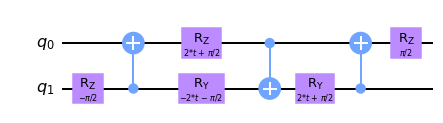

In [3]:
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import array_to_latex

from src.trotter_steps import add_three_cnot_decomposition

# there is missing pi/4 global phase, with this formulation
THREE_CNOT_DECOM_GLOBAL_PHASE = 1 / (2 ** (0.5)) * (1 - 1j)


def add_three_cnot_decomposition_paper_10(
    qc: QuantumCircuit,
    t: Parameter,
    q_0: QuantumRegister,
    q_1: QuantumRegister,
    remove_head: bool = False,
    remove_tail: bool = False,
) -> QuantumCircuit:
    """three cnot decomposition implementation with paper[10]"""
    qc.rz(-np.pi * 1 / 2, q_1)
    qc.cnot(q_1, q_0)
    qc.rz(1 / 2 * np.pi + 2 * t, q_0)
    qc.ry(-2 * t - 1 / 2 * np.pi, q_1)
    qc.cnot(q_0, q_1)
    qc.ry(+2 * t + 1 / 2 * np.pi, q_1)
    qc.cnot(q_1, q_0)
    qc.rz(np.pi * 1 / 2, q_0)
    return qc


t = Parameter(name="$t$")
qr = QuantumRegister(2)
N_t = add_three_cnot_decomposition_paper_10(qc=QuantumCircuit(qr), t=t, q_0=qr[0], q_1=qr[1])
qc = QuantumCircuit(2)
qc.append(N_t, [0, 1])

qc.decompose().draw(output="mpl")

* At my implementation center CNOT direction is flip

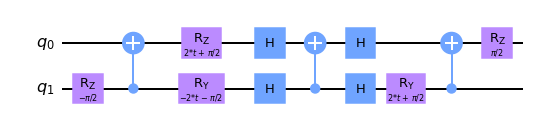

In [4]:
t = Parameter(name="$t$")
qr = QuantumRegister(2)
N_t = add_three_cnot_decomposition(qc=QuantumCircuit(qr), t=t, q_0=qr[0], q_1=qr[1])
qc = QuantumCircuit(2)
qc.append(N_t, [0, 1])

qc.decompose().draw(output="mpl")

* 6-CNOT decomposition at the circuit of contest github notebook

In [5]:
# from https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb
def append_ZZ(qc: QuantumCircuit, t: Parameter) -> QuantumCircuit:
    qc.cnot(0, 1)
    qc.rz(2 * t, 1)
    qc.cnot(0, 1)
    return qc


def append_XX(qc: QuantumCircuit, t: Parameter) -> QuantumCircuit:
    qc.ry(np.pi / 2, [0, 1])
    append_ZZ(qc, t=t)
    qc.ry(-np.pi / 2, [0, 1])
    return qc


def append_YY(qc: QuantumCircuit, t: Parameter) -> QuantumCircuit:
    qc.rx(np.pi / 2, [0, 1])
    append_ZZ(qc, t=t)
    qc.rx(-np.pi / 2, [0, 1])
    return qc


def get_baseline_one_trotter_step(t: float, num_qubits: int = 2) -> QuantumCircuit:
    Trot_qc = QuantumCircuit(num_qubits, name="Trot")
    append_ZZ(qc=Trot_qc, t=t)
    append_YY(qc=Trot_qc, t=t)
    append_XX(qc=Trot_qc, t=t)
    return Trot_qc


def get_nominal_one_trotter_step(t: float, num_qubits: int = 2) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits, name="Trot")
    qc.rzz(2 * t, 0, 1)
    qc.ryy(2 * t, 0, 1)
    qc.rxx(2 * t, 0, 1)

    return qc


baseline_qc = get_baseline_one_trotter_step(t=t)
nominal_qc = get_nominal_one_trotter_step(t=t)

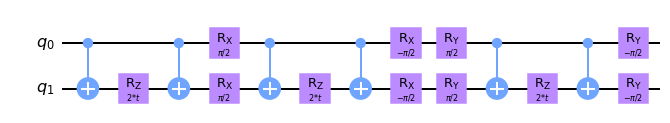

In [6]:
baseline_qc.draw("mpl")

test over 100 diffrent times

In [7]:
num_qubits = 2
target_times = np.linspace(0.01 * np.pi, np.pi, 100)
for target_time in target_times:
    # baseline qc
    baseline_qc = QuantumCircuit(num_qubits)
    unit_qc = get_baseline_one_trotter_step(t=target_time)
    baseline_qc.append(unit_qc.to_instruction(), [0, 1])

    # three cnot decomposition circuit
    qr = QuantumRegister(2)
    N_t = add_three_cnot_decomposition(qc=QuantumCircuit(qr), t=target_time, q_0=qr[0], q_1=qr[1])
    three_cnot_qc = QuantumCircuit(num_qubits)
    three_cnot_qc.append(N_t, [0, 1])

    # replace qc with unitary matrix
    baseline_unitary = qi.Operator(baseline_qc)
    three_cnot_unitary = qi.Operator(three_cnot_qc)

    # test whether these two unitary are the same
    assert np.all(
        np.array(baseline_unitary) - np.array(three_cnot_unitary / THREE_CNOT_DECOM_GLOBAL_PHASE) < 1.0e-15
    ), f"{target_time}"
print(f" 3-CNOT decomposition circuit equals to baseline 6-CNOT decomposition over all target_time: \n {target_times}")

 3-CNOT decomposition circuit equals to baseline 6-CNOT decomposition over all target_time: 
 [0.03141593 0.06283185 0.09424778 0.12566371 0.15707963 0.18849556
 0.21991149 0.25132741 0.28274334 0.31415927 0.34557519 0.37699112
 0.40840704 0.43982297 0.4712389  0.50265482 0.53407075 0.56548668
 0.5969026  0.62831853 0.65973446 0.69115038 0.72256631 0.75398224
 0.78539816 0.81681409 0.84823002 0.87964594 0.91106187 0.9424778
 0.97389372 1.00530965 1.03672558 1.0681415  1.09955743 1.13097336
 1.16238928 1.19380521 1.22522113 1.25663706 1.28805299 1.31946891
 1.35088484 1.38230077 1.41371669 1.44513262 1.47654855 1.50796447
 1.5393804  1.57079633 1.60221225 1.63362818 1.66504411 1.69646003
 1.72787596 1.75929189 1.79070781 1.82212374 1.85353967 1.88495559
 1.91637152 1.94778745 1.97920337 2.0106193  2.04203522 2.07345115
 2.10486708 2.136283   2.16769893 2.19911486 2.23053078 2.26194671
 2.29336264 2.32477856 2.35619449 2.38761042 2.41902634 2.45044227
 2.4818582  2.51327412 2.54469005 2.

## 2-4 Measurement Error Mitigation

From the qiskit textbook ["*Measurement Error Mitigation*" section](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html),
 I used the following qiskit module and get $ 8 \times 8 $ matrix for measurement error mitigation.
```python
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
```


## 2-5 Xgboost(data driven) Error Mitigation

### 2-5-1 formulation

Introducing "inverse" step for trotter step error which is illustrated at [FIG.2](#FIG.2:data_collection),
$$
\begin{align}
{U_{\text{trot}}}({\bf c} = (t/n, t/n, t/n)) =  U_{\text{plain}}(t/n) &= \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right] \\
{U_{\text{trot}}}^{\dagger}({\bf c} = (t/n, t/n, t/n)) = U_{\text{inverse}}(t/n) &=\left[\exp\left(\dfrac{+it}{n}H^{(1,2)}_{\text{Heis2}}\right) \exp\left(\dfrac{+it}{n}H^{(0,1)}_{\text{Heis2}} \right)\right]
\end{align}
$$
And all three circuit error below have the same trotter step cumulative error,

$$
\begin{align}
({\text{plain circuit}})(n=4, t) &= U_{\text{plain}}(t/n) U_{\text{plain}}(t/n) U_{\text{plain}}(t/n) U_{\text{plain}}(t/n) \\
({\text{half inverse circuit}})(n=4, t) &= U_{\text{plain}}(t/n) U_{\text{plain}}(t/n) U_{\text{inverse}}(t/n) U_{\text{inverse}}(t/n) \\
({\text{repeat inverse circuit}})(n=4, t) &= U_{\text{plain}}(t/n) U_{\text{inverse}}(t/n) U_{\text{plain}}(t/n) U_{\text{inverse}}(t/n)\ \text{or}\ \ U_{\text{inverse}}(t/n) U_{\text{plain}}(t/n) U_{\text{inverse}}(t/n) U_{\text{plain}}(t/n)
\end{align}
$$
where trotter steps $ n = 4 $ is chosen for display.

|   |
| --- |
|![inverse_circuits.png](images/inverse_circuits.png)|

Generally the expected state for the "plain circuit" can not be known but both "half inverse" and "repeat inverse" are result in Identity so we can always know
 initial state as the expected state at quantum computation. So we have define the error like below,

$$
\begin{align}
({\text{Error}_\text{trot}})_{kl} &= {}_{k}\langle \text{obs base} |\text{initial_state}\rangle_{l} - \frac{1}{S} \sum_{s}^S \left[ {}_{k}\langle \text{obs base} |({\text{half inverse circuit}})(n, t)|\text{initial_state} \rangle_{l} \right ] \\
({\text{Error}_\text{trot}})_{kl} &=  {}_{k}\langle \text{obs base} |\text{initial_state}\rangle_{l} - \frac{1}{S} \sum_{s}^S \left[  {}_{k}\langle \text{obs base}|({\text{repeat inverse circuit}})(n, t)|\text{initial_state}\rangle_{l} \right ]\\
  S &: \text{The number of the shots at quantum computation} \\
  k &:\text{Observation base index}\ 0,1,2,...2^{N=3} \\
  l &:\text{initial state index}\ 0,1,2,...2^{N=3}
\end{align}
$$
We can use the same base for both $ |\text{initial_state}\rangle_{l} $ and $ |\text{obs base} \rangle_{k}$, In this case, using kronecker delta $\delta_{kl}$,
$$
\begin{align}
({\text{Error}_\text{trot}})_{kl}   &= \delta_{kl} - \frac{1}{S} \sum_{s}^S \left[ {}_{k}\langle \text{obs base} |({\text{half inverse circuit}})(n, t)|\text{initial_state} \rangle_{l} \right ] \\
({\text{Error}_\text{trot}})_{kl} &= \delta_{kl} - \frac{1}{S} \sum_{s}^S \left[  {}_{k}\langle \text{obs base}|({\text{repeat inverse circuit}})(n, t)|\text{initial_state}\rangle_{l} \right ]\\
\end{align}
$$

Introducing a "regression" model $Y(n, {\bf c} = (t/n, t/n, t/n), l; {\bf w})$ with model parameters ${\bf w})$ on predicting ${\text{Error}_\text{trot}}$ and using l2 loss as loss function here,
$$
\begin{align}
 \text{l2 loss}_{l}({\bf w}) &= \sum_{k}[(({\text{Error}_\text{trot}})_{kl}  -Y(n, t/n, l; {\bf w})_{kl})^2]
\end{align}
$$
Topically in machine learning, we have $M$ samples and find optimized model parameters ${\bf w^{*}}$ which are minimizing loss, and expect that model can approximate $\text{Error}_\text{trot}$
$$
\begin{align}
 {\bf w^{*}} = \text{argmin}_{\bf w} & \sum_{m=1}^{M} \left[\text{l2 loss}_{l}({\bf w}) \right] \\
 \text{Error}_\text{trot} & \approx Y(n, {\bf c}, l; {\bf w}^{*}) \\
\end{align}
$$
There are several options for how to optimizing parameters ${\bf w^*}$ at machine learning. I choose xgboost[11].

Machine learning model is really flexible in inputs/outputs design.
I utilized this feature to improve model performance and prevent from overfitting.

#### Input extension
We can input over 100 different kinds inputs on a machine learning model if we have enough data and appropriate loss definition.
* Collecting current caribration data by IBMQ like "T1", "T2" and others, [FIG.5](#FIG.5:input_output_at_each_phase). Details of this selection is [here](#2-5-2-Data-Contents), Pass it to a machine learning model with other inputs, "initial state", "trotter steps", and "single step time" and then geting prediction of error probability for all observation $ 2^{N} (N=3)$ states.
    - These extended inputs(T1,,) contributed to the model. It was confirmed [here](#Check-the-input-feature-importance).

#### Different input/output for each phase
* At the inference time, to get normal calibration matrix, input state is augmented and generate 8x8 calibration matrix for each circuit.[FIG.5](#FIG.5:input_output_at_each_phase)
    + At training time, a XGBoost new feature "[multi output](https://xgboost.readthedocs.io/en/latest/tutorials/multioutput.html)" was used. So at the implementation we don't have to make $2^{N=3} $ XGBoost models explicitly for each output state, XGBoost library can handle these stuff instead.

| |input per circuit | output per circuit | Outcome |
| --- | --- | ---- | --- |
| Training Time| 1 state  | $ 2^{N=3} $ states with "[XGBoost multi output](https://xgboost.readthedocs.io/en/latest/tutorials/multioutput.html)" | state error  $ 2^{N=3} $ dim vector |
|Inference time| Augmented  $ 2^{N=3} $ states |  $ 2^{N=3} $ output $ \times $ $ 2^{N=3} $ states| $ 2^{N=3} \times  2^{N=3} $ full calibration matrix |

| <a id="FIG.5:input_output_at_each_phase"></a>| 
| --- | 
|![each_phase](./images/input_output_at_each_phase.png)|
|**FIG.5: Different Input/Output for each phase** |


----------------------
**Reference**

\[11\] Chen, T. and Guestrin, C *XGBoost: A Scalable Tree Boosting System*, \[[arxiv version](https://arxiv.org/abs/1603.02754)\]


### 2-5-2 Data Contents:

#### Input features
* two categories
    - DATSET_META: the configuration data for circuit to be run.
    - calibration data from backend: the definition of current circuit state

```python
# Meta feature about input circuit
DATASET_META = [
    "trotter_steps",     # trotter_steps, n
    "single_step_time",  # target_time/trotter_steps
    "initial_state_q5",  # 0 or 1
    "initial_state_q3",  # 0 or 1
    "initial_state_q1",  # 0 or 1
]
# Data from backend.properties(). Choose only independent features.
calib_data_input_features = [
        'T1_us_q1', 'T1_us_q3', 'T1_us_q5',
       'frequency_GHz_q1', 'frequency_GHz_q3', 'frequency_GHz_q5',
       'gate_error_cx1_3', 'gate_error_cx3_1', 'gate_error_cx3_5',
       'gate_error_cx5_3', 'gate_error_x1', 'gate_error_x3', 'gate_error_x5'
]
```
#### Target/Label data

* Set measurement for all three qubits and collecting $2^{N=3}$ counts.
* Use the counts/shots as machine learning target/label data.

```python
# Data from IBMQ result. use counts for each state.
OBSERVE_STATES_3_QUBITS = ("000", "001", "010", "011", "100", "101", "110", "111")

```


#### How to get/use calibration data from backend

In [8]:
from run_circuit import get_backend
from src.error_mitigation_learning import (
    filter_features,
    make_col_aligned_dataframe_groupby,
    parse_backend_properties_as_dataframe,
)
from src.run_mode_definitions import BackendName

# preprocess for xgb model
jakarta, _ = get_backend(backend_name=BackendName.JAKARTA)
# get prop from IBMQ
jakarta_prop = jakarta.properties()

qubit_df, gate_df = parse_backend_properties_as_dataframe(jakarta_props=[jakarta_prop])
qubit_df = make_col_aligned_dataframe_groupby(row_aligned_df=qubit_df, key="qubit")
gate_df = make_col_aligned_dataframe_groupby(row_aligned_df=gate_df, key="gate_name")
# drop features
gate_df, qubit_df = filter_features(gate_df=gate_df, qubit_df=qubit_df, mode="minimum")
calib_df = pd.merge(left=qubit_df, right=gate_df, on=["sample_index", "last_update_date"])

ibmqfactory.load_account:WARNING:2022-04-24 03:37:45,329: Credentials are already in use. The existing account in the session will be replaced.


use minimum features for calibration data


In [9]:
calib_df.columns

Index(['sample_index', 'last_update_date', 'T1_us_q1', 'T1_us_q3', 'T1_us_q5',
       'frequency_GHz_q1', 'frequency_GHz_q3', 'frequency_GHz_q5',
       'gate_error_cx1_3', 'gate_error_cx3_1', 'gate_error_cx3_5',
       'gate_error_cx5_3', 'gate_error_x1', 'gate_error_x3', 'gate_error_x5'],
      dtype='object')

### 2-5-3 Input Data Generation: Sampling Strategy


Sweep following features
```python
sampling_sweep_features = [
    "initial_state",           # |000>,|001>..., |111>
    "trotter_steps",           # 2,4,6,...12
    "single_step_time",        # target_time/trotter_steps
    "inverse_mode",            # HALF,REPEAT,
    "operation_order_in_step", # 1-3/3-5 or 3-5/1-3, which subsystem qr13 or qr35 are firstly evaluated at circuit for each step
]

```

But computation time at IBMQ is extremely limited, So I set two strategy for data sampling,

* strategy 1: Try fine gird sampling around  target $ H_{\text{Heis}} $ & initial_state $ |110 \rangle $
* strategy 2: wide & shallow initial_state sampling for calibrating single trotter step

and the table below is detail settings. Based on this sampling strategy, run total ~100 jobs on IBMQ for data generation.

|| Sampling Strategy |is_single_step_calib |initial_state |single_step_time | inverse_mode|operation_order_in_step|
| -- |-- | --- | --- | --- |--- | --- |
| 1 |for target $ H_{\text{Heis}} $ & initial_state  | False | only  110  | different 23 time |All | qr13/35 |
| 2 |for single trotter step calibration   | True |ALL | only different 3 time |REPEAT | ALL | All |

#### Check the generated data statistics

In [ ]:
from src.carib import OBSERVE_STATES_3_QUBITS, CalibName
from src.error_mitigation_learning import preprocess_dataframe_dataset

calib_dataset_path = Path("./your_quantum_device_run_result.csv")
dataset_df = pd.read_csv(calib_dataset_path)
dataset_df = preprocess_dataframe_dataset(df=dataset_df, state_labels=OBSERVE_STATES_3_QUBITS)
dataset_df = dataset_df.loc[dataset_df.calib_name == CalibName.TROTTER_INVERSE]
dataset_df.head()

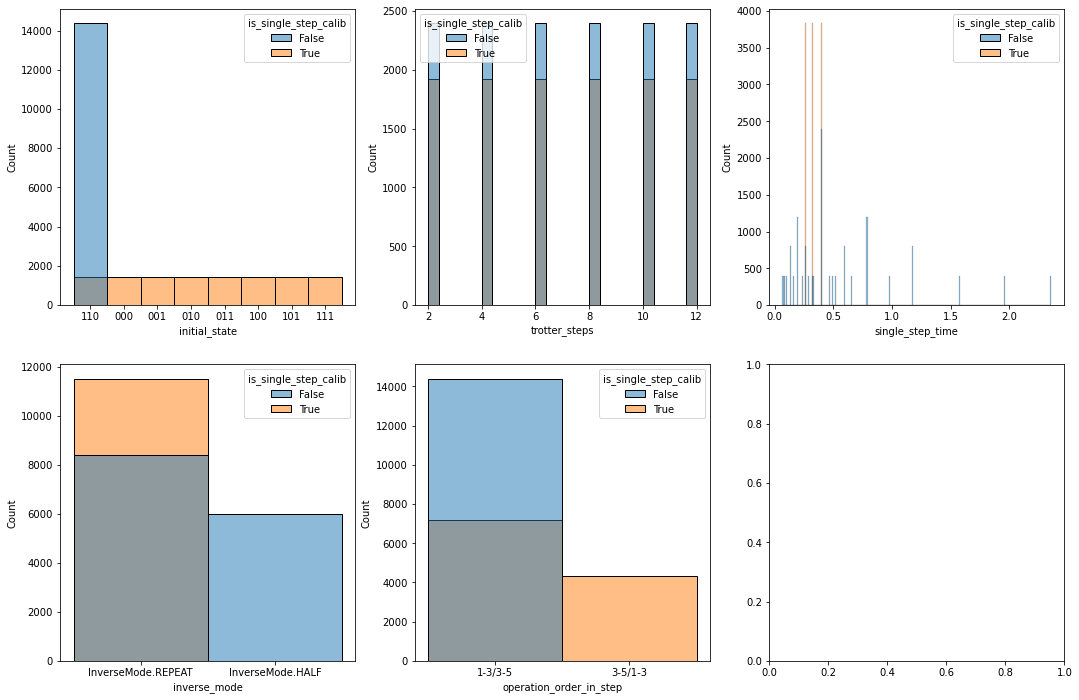

In [11]:
sampling_sweep_features = [
    "initial_state",
    "trotter_steps",
    "single_step_time",
    "inverse_mode",
    "operation_order_in_step",
]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.reshape(-1)
for feat_index, sampling_feature in enumerate(sampling_sweep_features):
    sns.histplot(dataset_df, x=sampling_feature, ax=axes[feat_index], hue="is_single_step_calib")

#### Genereate circuits for several cases

Text(0.5, 1.0, 'Data collection for trotter step error: Repeat inverse circuit qr35-13')

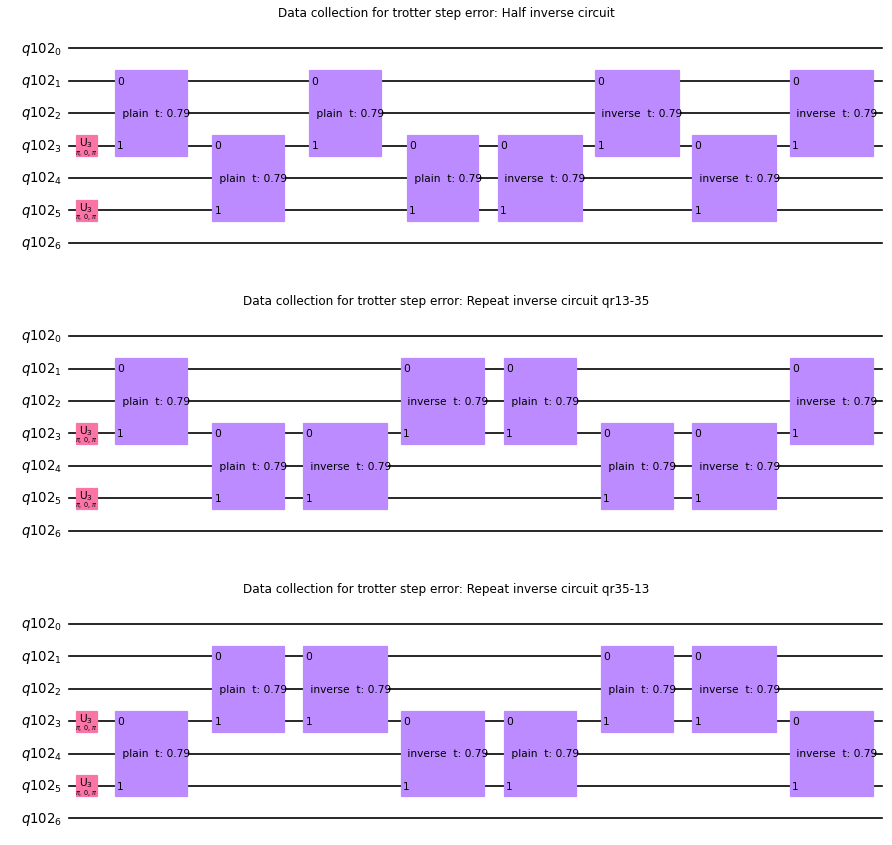

In [12]:
from src.open_science_prize_requirements import prepare_initial_state_open_science_prize
from src.trotter_steps import (
    TrotterSingleStep,
    TrotterUnitQc,
    generate_trotter_n_steps_on_qc,
)

trotter_steps = 4
qc, target_time, _ = prepare_initial_state_open_science_prize(trotter_steps=trotter_steps)

trotter_single_step_qr13_qr35 = TrotterSingleStep(
    name="single_step", num_qubits=3, qrs_for_each_qc={0: [0, 1], 1: [1, 2]}
)
trotter_single_step_qr35_qr13 = TrotterSingleStep(
    name="single_step", num_qubits=3, qrs_for_each_qc={0: [1, 2], 1: [0, 1]}
)

trotter_qcs = (
    TrotterUnitQc(name="", key="NORMAL", flip_cnot_directions=[False, True, False]),
    TrotterUnitQc(name="", key="NORMAL", flip_cnot_directions=[False, True, False]),
)

_append_step = partial(
    generate_trotter_n_steps_on_qc, trotter_qcs=trotter_qcs, trotter_steps=trotter_steps, target_time=target_time
)

plain = _append_step(
    initial_qc=deepcopy(qc),
    trotter_single_step=trotter_single_step_qr13_qr35,
    is_inverse_step=[False, False, False, False],
)
half_inv = _append_step(
    initial_qc=deepcopy(qc),
    trotter_single_step=trotter_single_step_qr13_qr35,
    is_inverse_step=[False, False, True, True],
)
repeat_inv_qr13_qr35 = _append_step(
    initial_qc=deepcopy(qc),
    trotter_single_step=trotter_single_step_qr13_qr35,
    is_inverse_step=[False, True, False, True],
)
repeat_inv_qr35_qr13 = _append_step(
    initial_qc=deepcopy(qc),
    trotter_single_step=trotter_single_step_qr35_qr13,
    is_inverse_step=[False, True, False, True],
)


fig, axes = plt.subplots(3, 1, figsize=(20, 15))

half_inv.decompose().draw(output="mpl", ax=axes[0])
repeat_inv_qr13_qr35.decompose().draw(output="mpl", ax=axes[1])
repeat_inv_qr35_qr13.decompose().draw(output="mpl", ax=axes[2])
axes[0].set_title("Data collection for trotter step error: Half inverse circuit")
axes[1].set_title("Data collection for trotter step error: Repeat inverse circuit qr13-35")
axes[2].set_title("Data collection for trotter step error: Repeat inverse circuit qr35-13")

### 2-5-4 Training

* Xgboost is very famous model for csv/table data.
* There is well developed package and easy to train.
* Difficult part is arranging the data into csv/table format.


I follow really basic work flow.
> collecting csv data -> train/val data split -> scale each feature -> training -> validation -> save a taining model for inference



#### collecting csv data, simply loading cached data here

In [13]:
import xgboost as xgb
from hydra import compose, initialize_config_dir
from sklearn.preprocessing import StandardScaler

from run_error_mitigation_learning import REMOVE_CALIB_NAMES
from src.carib import OBSERVE_STATES_3_QUBITS, CalibName
from src.error_mitigation_learning import (
    DATASET_META,
    GATE_NAMES_IN_JAKARTA,
    GATE_PROPERTY_NAMES,
    QUBIT_PROPERTY_NAMES,
    filter_features,
    get_xgboost_save_path,
    initial_state_augmentation,
    make_col_aligned_dataframe_groupby,
    make_split,
    parse_backend_properties_as_dataframe,
    preprocess_dataframe_dataset,
    set_local_tz_from_strings,
    visualize_properties,
)
from src.utils import fix_seed

XGBOOST_CONF_PATH = Path("./src/config/config_xgboost.yaml")
conf = OmegaConf.load(XGBOOST_CONF_PATH)
# parse config
gate_path = Path(conf.cached_data.backend_properties.gate_path)
qubit_path = Path(conf.cached_data.backend_properties.qubit_path)
cache_dataset_path = Path(conf.cached_data.dataset_csv_path)
save_dir_path = Path(conf.save_dir_path)
save_dir_path.mkdir(exist_ok=True)

fix_seed(seed=conf.seed)

gate_df = pd.read_csv(gate_path)
qubit_df = pd.read_csv(qubit_path)
gate_df = set_local_tz_from_strings(df=gate_df, target_column="last_update_date")
qubit_df = set_local_tz_from_strings(df=qubit_df, target_column="last_update_date")

# drop features
gate_df, qubit_df = filter_features(gate_df=gate_df, qubit_df=qubit_df, mode="minimum")
calib_df = pd.merge(left=qubit_df, right=gate_df, on=["sample_index", "last_update_date"])
calib_columns = calib_df.iloc[:, 2:].columns.to_list()

# cached dataset contains counts after CompleteMeasFilter applied
dataset_df = pd.read_csv(cache_dataset_path)
dataset_df = preprocess_dataframe_dataset(
    df=dataset_df,
    state_labels=OBSERVE_STATES_3_QUBITS,
)
# merge with backend_properties data and counts data
merged_df = pd.merge_asof(
    left=dataset_df,
    right=calib_df,
    left_on="job_start_time",
    right_on="last_update_date",
    direction="backward",
)
assert np.all(merged_df["job_start_time"] > merged_df["last_update_date"])

# get only plain qc dataframe as additional validation data
plain_qc_df = merged_df.loc[merged_df["calib_name"] == CalibName.NO_CALIB].reset_index(drop=True)
# initial state augmentation for 8 x 8 matirc prediction
plain_qc_df = initial_state_augmentation(df=plain_qc_df, state_labels=OBSERVE_STATES_3_QUBITS)

for remove_calib_name in REMOVE_CALIB_NAMES:
    print(f"remove samples from train/val set: {remove_calib_name}")
    mask = merged_df["calib_name"] != remove_calib_name
    merged_df = merged_df.loc[mask]

use minimum features for calibration data
remove samples from train/val set: CalibName.NO_CALIB
remove samples from train/val set: CalibName.MEAS


#### Start training and saving a model

In [14]:
def visualize_learning_curve(training_res: Dict[str, Dict[str, np.ndarray]], fold: int = 0) -> None:
    fig, ax = plt.subplots()
    ax.plot(training_res["validation_0"]["rmse"], label="train")
    ax.plot(training_res["validation_1"]["rmse"], label="validation")
    plt.legend()
    ax.set_title(f"Xgboost Learning curve: Validation Fold:{fold}")
    ax.set_ylabel("l2 loss")
    ax.set_xlabel("step")
    plt.grid()
    plt.show()

Complete training val fold 0


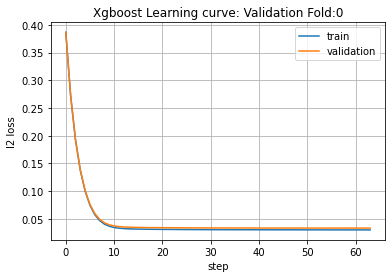

Complete training val fold 1


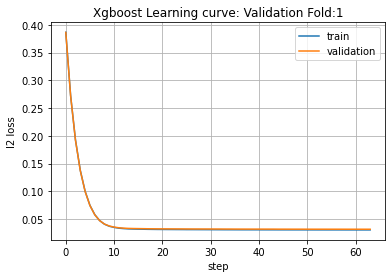

Complete training val fold 2


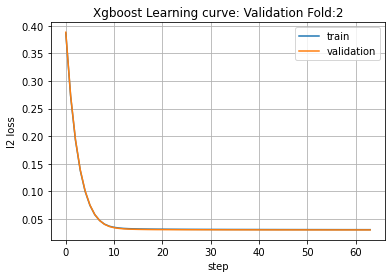

Complete training val fold 3


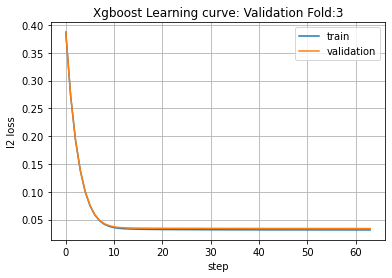

Complete training val fold 4


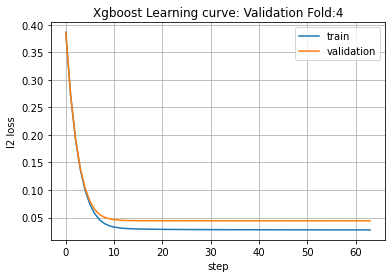

In [15]:
merged_df = make_split(df=merged_df, n_splits=conf.n_splits, target_key="job_id", group_key="job_id", how="group")

# Start n_splits cross validation
for val_fold in range(conf.n_splits):
    # train/val split
    train_df = merged_df.loc[merged_df["fold"] != val_fold, :]
    val_df = merged_df.loc[merged_df["fold"] == val_fold, :]
    # generate input/label data for model
    X_train = train_df.loc[:, DATASET_META + calib_columns].to_numpy()
    y_train = train_df.loc[:, OBSERVE_STATES_3_QUBITS].to_numpy()
    X_val = val_df.loc[:, DATASET_META + calib_columns].to_numpy()
    y_val = val_df.loc[:, OBSERVE_STATES_3_QUBITS].to_numpy()
    # scale input data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    # Train a regressor on it
    reg = xgb.XGBRegressor(
        tree_method="hist",
        n_estimators=conf.xgboost.n_estimators,
        # early_stopping_rounds=conf.early_stopping_rounds,
    )
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

    # additional validation
    X_plain = plain_qc_df.loc[:, DATASET_META + calib_columns].to_numpy()
    y_plain = plain_qc_df.loc[:, OBSERVE_STATES_3_QUBITS].to_numpy()
    X_plain = scaler.transform(X_plain)
    pred_plain = reg.predict(X_plain)
    loss = np.sqrt(((pred_plain - y_plain) ** 2).sum(axis=-1))

    pred_df = pd.DataFrame(
        pred_plain.astype(np.float64), columns=[state + "_pred" for state in OBSERVE_STATES_3_QUBITS]
    )
    pred_df = pd.concat([plain_qc_df, pred_df], axis=1)

    # save each objects, model, prediction and input configuration...
    xgb_save_path = get_xgboost_save_path(save_dir_path=save_dir_path, val_fold=val_fold)
    # Save model into JSON format.
    # Json format contains both model structure and training hyperparameter
    reg.save_model(xgb_save_path.model)
    with xgb_save_path.scaler.open("wb") as f:
        pickle.dump(scaler, f)
    with xgb_save_path.input_feature.open("w") as f:
        json.dump(DATASET_META + calib_columns, f)
    pred_df.to_csv(xgb_save_path.pred_df, index=False)
    # monitor training
    print(f"Complete training val fold {val_fold}")
    visualize_learning_curve(training_res=reg.evals_result(), fold=val_fold)

### Check the input feature importance
After training contribution to each feature for the trained model can be checked with [official api](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.plotting)
* We can see "trotter step" and "single time step" are dominant feature to the model as expected.
* Gate related errors do not contribute it
    * Contray to the gate, frequent update data "T1" is much important.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

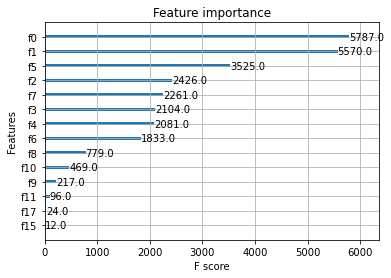

In [16]:
xgb.plot_importance(reg.get_booster())

In [17]:
# feat index : name dict at figure above
[f"f{feat_ind}: {feat_name}" for feat_ind, feat_name in enumerate(DATASET_META + calib_columns)]

['f0: trotter_steps',
 'f1: single_step_time',
 'f2: initial_state_q5',
 'f3: initial_state_q3',
 'f4: initial_state_q1',
 'f5: T1_us_q1',
 'f6: T1_us_q3',
 'f7: T1_us_q5',
 'f8: frequency_GHz_q1',
 'f9: frequency_GHz_q3',
 'f10: frequency_GHz_q5',
 'f11: gate_error_cx1_3',
 'f12: gate_error_cx3_1',
 'f13: gate_error_cx3_5',
 'f14: gate_error_cx5_3',
 'f15: gate_error_x1',
 'f16: gate_error_x3',
 'f17: gate_error_x5']

### 2-5-5 Inference

* inference time, input state is  augmented and generate 8x8 calibration matrix for a single circuit.


| |input per circuit | output per circuit | Outcome |
| --- | --- | ---- | --- |
| Training Time| 1 state  | $ 2^{N=3} $ states with "[XGBoost multi output](https://xgboost.readthedocs.io/en/latest/tutorials/multioutput.html)" | state error  $ 2^{N=3} $ dim vector |
|Inference time| Augmented  $ 2^{N=3} $ states |  $ 2^{N=3} $ output $ \times $ $ 2^{N=3} $ states| $ 2^{N=3} \times  2^{N=3} $ full calibration matrix |


#### Loading IBMQ results

* Firstly loading local cached python object for experiment logging

In [ ]:
import sys

import src.open_science_prize_requirements as __pickle_patch_for_open_sci_prize
from src.logger.exp_logger import ExpLog, retrieve_job_from_ibmq

# when load old pickle, need old module name
sys.modules["src.open_science_prize_requiments"] = __pickle_patch_for_open_sci_prize

exp_log_path = Path("./your_ibmq_job_result_with_exp_log_format.pickle")

job_path = Path("./your_ibmq_job_result.pickle")
# All input and output are in this ExpLog class
exp_log = ExpLog.load_from_pickle(path=exp_log_path)
print(f"Several info are contained in exp_log, \n job_ids: {exp_log.job_ids},\n qc_info: {exp_log.qc_job} ....")

* Retrieve job from IBMQ

In [19]:
try:
    jakarta, _ = get_backend(backend_name=BackendName.JAKARTA)
    jobs = retrieve_job_from_ibmq(backend=jakarta, job_ids=exp_log.job_ids)
except:
    print(
        f"Could not retrieve job id: {exp_log.job_ids} with current account, so loading pickled job instance from cached directory"
    )
    with job_path.open("rb") as f:
        jobs_loaded = pickle.load(f)

ibmqfactory.load_account:WARNING:2022-04-24 03:38:04,235: Credentials are already in use. The existing account in the session will be replaced.


In [20]:
import xgboost as xgb

from run_circuit import get_job_result
from run_error_mitigation_learning import (
    REMOVE_CALIB_NAMES,
    back_to_probability,
    prepare_filter_by_xgb_prediction,
)
from src.carib import OBSERVE_STATES_3_QUBITS, CalibName
from src.error_mitigation_learning import (
    DATASET_META,
    GATE_NAMES_IN_JAKARTA,
    GATE_PROPERTY_NAMES,
    QUBIT_PROPERTY_NAMES,
    filter_features,
    get_xgboost_save_path,
    initial_state_augmentation,
    make_col_aligned_dataframe_groupby,
    make_split,
    parse_backend_properties_as_dataframe,
    preprocess_dataframe_dataset,
    set_local_tz_from_strings,
    visualize_properties,
)
from src.open_science_prize_requirements import TARGET_TIME

XGBOOST_CONF_PATH = Path("./src/config/config_xgboost.yaml")
conf = OmegaConf.load(XGBOOST_CONF_PATH)
# parse config
save_dir_path = Path(conf.save_dir_path)

* Run inference

In [21]:
# xgb model loading
xgb_save_path = get_xgboost_save_path(save_dir_path=save_dir_path, val_fold=4)
reg = xgb.XGBRegressor()
reg.load_model(xgb_save_path.model)
with xgb_save_path.scaler.open("rb") as f:
    scaler = pickle.load(f)
with xgb_save_path.input_feature.open("r") as f:
    input_feature_names = json.load(f)

# preprocess for xgb model
jakarta, _ = get_backend(backend_name=BackendName.JAKARTA)
jakarta_props = []
job_datetimes = []
for job in jobs:
    # get prop from IBMQ with the datetime of job
    jakarta_prop = jakarta.properties(refresh=True, datetime=job.time_per_step()["RUNNING"])
    job_datetime = job.time_per_step()["RUNNING"]

    jakarta_props.append(jakarta_prop)
    job_datetimes.append(job_datetime)

qubit_df, gate_df = parse_backend_properties_as_dataframe(jakarta_props=jakarta_props)
qubit_df = make_col_aligned_dataframe_groupby(row_aligned_df=qubit_df, key="qubit")
gate_df = make_col_aligned_dataframe_groupby(row_aligned_df=gate_df, key="gate_name")
# drop features
gate_df, qubit_df = filter_features(gate_df=gate_df, qubit_df=qubit_df, mode="full")
calib_df = pd.merge(left=qubit_df, right=gate_df, on=["sample_index", "last_update_date"])

trotter_steps = exp_log.conf_at_request.trotter.steps
single_step_time = TARGET_TIME / trotter_steps
dataset_df = []
for job_datetime, job in zip(job_datetimes, jobs):
    dataset_df.append(
        {
            "job_start_time": job_datetime,
            "trotter_steps": trotter_steps,
            "single_step_time": single_step_time,
            "initial_state": "110",
            "calib_name": CalibName.NO_CALIB,
            "initial_state_q5": 1,
            "initial_state_q3": 1,
            "initial_state_q1": 0,
        }
    )
dataset_df = pd.DataFrame(dataset_df)

merged_df = pd.merge_asof(
    left=dataset_df, right=calib_df, left_on="job_start_time", right_on="last_update_date", direction="backward"
)
plain_qc_df = merged_df.loc[merged_df["calib_name"] == CalibName.NO_CALIB].reset_index(drop=True)
plain_qc_df = initial_state_augmentation(df=plain_qc_df, state_labels=OBSERVE_STATES_3_QUBITS)
X_plain = plain_qc_df.loc[:, input_feature_names].to_numpy()
X_plain = scaler.transform(X_plain)
pred_plain = reg.predict(X_plain)

pred_state_labels = [state + "_pred" for state in OBSERVE_STATES_3_QUBITS]
pred_df = pd.DataFrame(pred_plain.astype(np.float64), columns=pred_state_labels)
pred_df = pd.concat([plain_qc_df, pred_df], axis=1)

# xgb prediction is not probability, so cast to probability
pred_df = back_to_probability(df=pred_df, state_labels=pred_state_labels)
# get 8 x 8 matrix for error mitigation
xgb_pred_filters = prepare_filter_by_xgb_prediction(plain_qc_df=pred_df, pred_state_labels=pred_state_labels)

ibmqfactory.load_account:WARNING:2022-04-24 03:38:08,997: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# 8 x 8 matrix
xgb_pred_filters[0].cal_matrix.shape, xgb_pred_filters[0].cal_matrix
#
# Plot the XGB calibration matrix
# xgb_pred_filters[0].plot_calibration()

#### Comparison w/wo xgb filter
* ~0.4 improvement are confirmed
* In this run, there no asemble for all val fold. but the main code use all 5 models for inference filter.

In [ ]:
print("using job", exp_log_path)
print("start evaluation: without xgb")
exp_log_without_xgb = get_job_result(jobs=jobs, exp_log=deepcopy(exp_log), xgb_pred_filters=None)
print(f"State tomo fidelity: {np.mean(exp_log_without_xgb.fids):>5.3f}")  # store the job results
print("start evaluation: with xgb")
exp_log_with_xgb = get_job_result(jobs=jobs, exp_log=deepcopy(exp_log), xgb_pred_filters=xgb_pred_filters)
print(f"State tomo fidelity: {np.mean(exp_log_with_xgb.fids):>5.3f}")

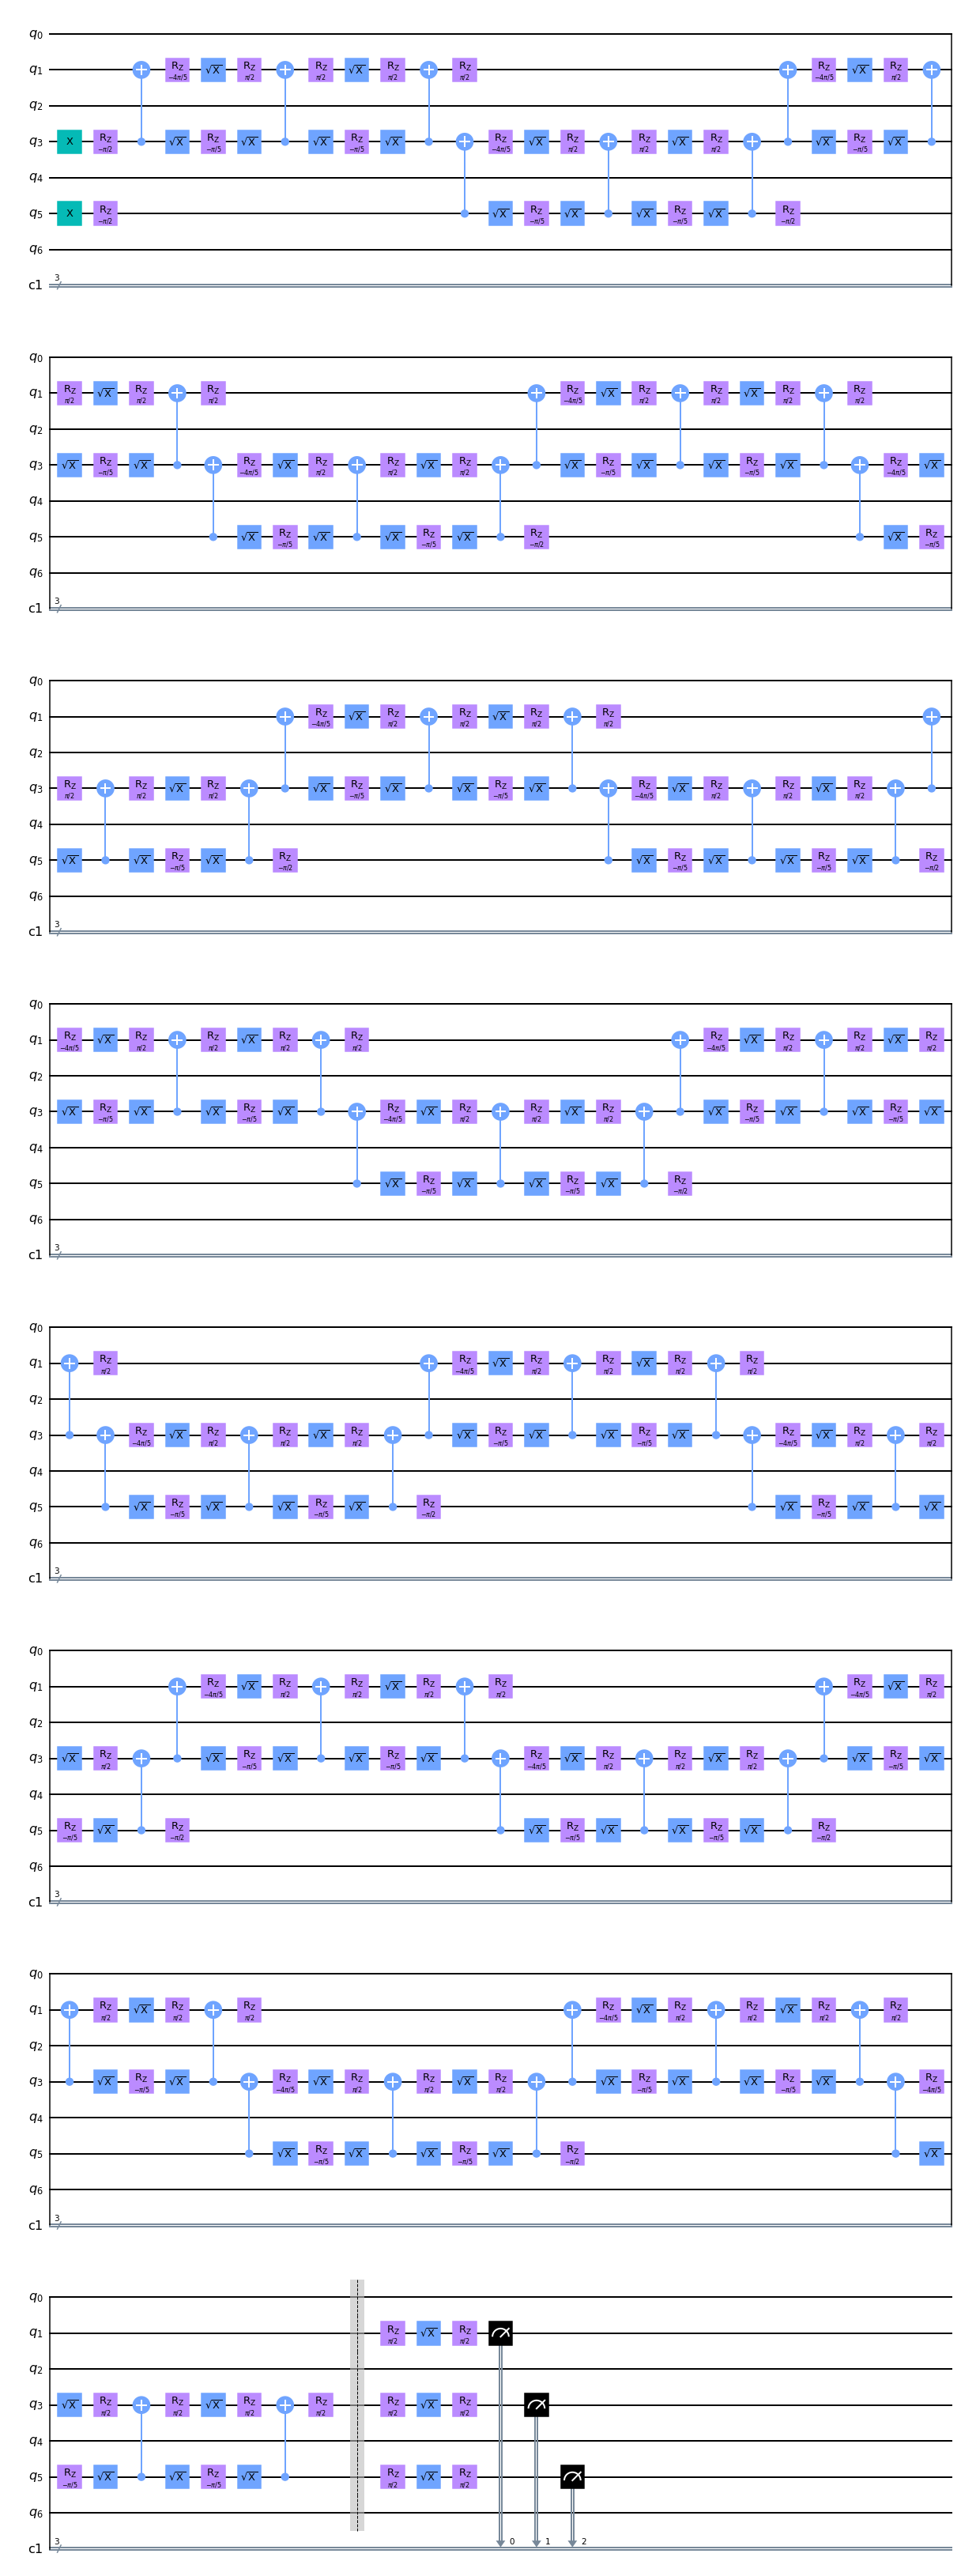

In [25]:
jobs[0].circuits()[0].draw("mpl")

# 3 Code run

* Runing my code, from initial circuit definition to final state tomography evaluation

## Set IBMQ or Aer(Local) Calculation

* Overriding src/config.yaml value with the following value for this notebook run.

In [42]:
from src.run_mode_definitions import BackendName

BACKEND_NAME = BackendName.JAKARTA  # job at IBMQ, real quantum device,
# BACKEND_NAME = BackendName.NOISY_SIM  #  job at a local machine, noisy simulation

## Imports

In [43]:
import logging
import sys
from pathlib import Path

from hydra import compose, initialize_config_dir
from omegaconf import OmegaConf

from run_circuit import (
    process_calib_jobs,
    request_single_experiment,
    run_calibration_data_generation,
    run_evaluation,
)
from src.logger.exp_logger import ExpLog, monitor_submitted_job_state, run_exp_logging
from src.run_mode_definitions import (
    BackendName,
    RunMode,
    TargetProcess,
    update_config_and_set_evaluation_args,
)
from src.trotter_steps import TrotterSingleStep, TrotterUnitQc
from src.utils import adjust_qiskit_logging_level, fix_seed

## Config file load  and General settings

loading config file

In [44]:
CONFIG_DIR = Path(Path.cwd(), "src", "config")
with initialize_config_dir(config_dir=str(CONFIG_DIR)):
    conf = compose("config.yaml")

In [45]:
# parse config
run_mode = RunMode[conf.run_mode]
target_process = TargetProcess[conf.target_process]
# NOTE: Not using the config setting in this notebook
# backend_name = BackendName[conf.backend_name]
backend_name = BACKEND_NAME
xgboost_save_path = Path(conf.xgboost.load.path) if conf.xgboost.load.path is not None else None

trotter_single_step = TrotterSingleStep(**conf.trotter.single_step)
trotter_qcs = (
    TrotterUnitQc(**conf.trotter.unit_qc.qr13),
    TrotterUnitQc(**conf.trotter.unit_qc.qr35),
)
exp_log_path = Path(conf.exp_log_path)
job_table_path = Path(conf.job_table_path)

general settings

In [46]:
fix_seed(seed=conf.seed)
adjust_qiskit_logging_level(logging_level=logging.WARNING)

logging settings for jupyter

In [47]:
# from https://teramonagi.hatenablog.com/entry/20170201/1485917670
# log = logging.getLogger(__name__)
# Please run this cell once, otherwise same log will output multiple times
log = logging.getLogger()
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
log.addHandler(handler)
log.setLevel(logging.INFO)

### Set wheather using my trained XGBoost model or trained with this notebook
* You can switch the xgboost model for fidelity evaluation
    1. USE_CACHED_XGB_MODEL = True -> loading my trained xgboost model
    2. USE_CACHED_XGB_MODEL = False -> try to loading your trained model at this notebook, section 2.
        - If any available path are detected, then cached model will be used

In [ ]:
USE_CACHED_XGB_MODEL = False
if not USE_CACHED_XGB_MODEL:
    xgb_conf = OmegaConf.load(XGBOOST_CONF_PATH)
    # parse config
    save_dir_path = Path(xgb_conf.save_dir_path)
    # save each objects, model, prediction and input configuration...
    xgb_save_path = get_xgboost_save_path(save_dir_path=save_dir_path, val_fold=0)
    if xgb_save_path.model.exists() & xgb_save_path.scaler.exists() & xgb_save_path.input_feature.exists():
        print(f"xgboost path is updated from {xgboost_save_path} to {save_dir_path}")
        xgboost_save_path = save_dir_path
    else:
        print(f"Cannot find model on {save_dir_path}, so cached model will be used")

## IBMQ/Aer JOB submission

In [49]:
if run_mode & RunMode.SUBMIT_JOB:
    log.info("Start job submission...")
    jobs, calib_jobs, exp_log_wo_results = request_single_experiment(
        backend_name=backend_name,
        target_process=target_process,
        trotter_steps=conf.trotter.steps,
        trotter_qcs=trotter_qcs,
        trotter_single_step=trotter_single_step,
        meas_calib_conf=conf.carib,
        calib_trotter_is_inverses=conf.calib_trotter.is_inverse_step,
        calib_trotter_step_list=conf.calib_trotter.trotter_steps_list,
        calib_sample_times=conf.calib_trotter.sample_times,
        calib_trotter_qubit_list=conf.calib_trotter.qubit_list,
        optimization_level=conf.transpile.optimization_level,
        seed_transpiler=conf.seed,
        seed_simulator=conf.seed,
        job_tags=conf.neptune_logger.tags,
    )
    exp_log_wo_results.conf_at_request = conf
    # try to store calibration results, if jobs are DONE.
    exp_log_wo_results, _ = process_calib_jobs(
        calib_jobs=calib_jobs, exp_log=exp_log_wo_results, target_process=target_process
    )
    exp_log_wo_results.save_as_pickle(path=exp_log_path)

Start job submission...
Start job submission...


ibmqfactory.load_account:WARNING:2022-04-24 03:42:22,371: Credentials are already in use. The existing account in the session will be replaced.


backend: BackendName.JAKARTA
backend: BackendName.JAKARTA
Preparing measurement caribration on qr:[1, 3, 5] ...
Preparing measurement caribration on qr:[1, 3, 5] ...
Decomposed unit trotter_step, 
                      ┌───┐┌───────────┐ ┌───┐┌───┐┌───┐             ┌───┐»
q6202_0: ────────────┤ X ├┤ Rz(7π/10) ├─┤ H ├┤ X ├┤ H ├─────────────┤ X ├»
         ┌──────────┐└─┬─┘├───────────┴┐├───┤└─┬─┘├───┤┌───────────┐└─┬─┘»
q6202_1: ┤ Rz(-π/2) ├──■──┤ Ry(-7π/10) ├┤ H ├──■──┤ H ├┤ Ry(7π/10) ├──■──»
         ├──────────┤     └────────────┘└───┘     └───┘└───────────┘     »
q6202_2: ┤ Rz(-π/2) ├────────────────────────────────────────────────────»
         └──────────┘                                                    »
«         ┌─────────┐                                                          
«q6202_0: ┤ Rz(π/2) ├──────────────────────────────────────────────────────────
«         └──┬───┬──┘┌───────────┐ ┌───┐┌───┐┌───┐             ┌───┐┌─────────┐
«q6202_1: ───┤ X ├───┤ Rz(7π/10) ├─┤ 

In [ ]:
if (run_mode == RunMode.ALL) & (backend_name == BackendName.JAKARTA):
    # IBMQ job needs hours or days, so check the state before move onto job evaluation
    monitor_submitted_job_state(jobs=list(calib_jobs.values()) + jobs)

Job status check, JOB ID: 6264c7241c8b93bda87dbd8a
Job status check, JOB ID: 6264c7241c8b93bda87dbd8a
Job Status: job is queued (455)

## Job Evaluation

In [ ]:
if run_mode & RunMode.EVALUATE:
    log.info("Start job evaluation...")
    if target_process == TargetProcess.DATASET_GENERATION:
        dataset = run_calibration_data_generation(
            job_table_path=job_table_path, backend_name=backend_name, target_process=target_process
        )
        df = dataset.get_dataframe()
        calib_csv_path = Path("./calib_dataset.csv")
        log.info(f"save csv dataset at {calib_csv_path.absolute()}")
        df.to_csv(calib_csv_path, index=False)

    else:
        exp_log_loaded = ExpLog.load_from_pickle(path=exp_log_path)

        conf, evaluation_kwargs = update_config_and_set_evaluation_args(
            conf_new=conf, conf_old=exp_log_loaded.conf_at_request
        )
        exp_log = run_evaluation(
            exp_log=exp_log_loaded,
            backend_name=backend_name,
            target_process=target_process,
            xgboost_save_path=xgboost_save_path,
            jobs=None if run_mode == RunMode.EVALUATE else jobs,
            calib_jobs=None if run_mode == RunMode.EVALUATE else calib_jobs,
            **evaluation_kwargs,
        )
        # loggin with neptune logger, if no neptune simply ignored
        run_exp_logging(conf=conf, exp_log=exp_log, log_level=log.getEffectiveLevel())

# Appendix

## Comparison: Other CNOT decomposition

* NORMAL: here my default CNOT decomposition used this study[10]
* QISKIT_KAK: use qiskit class -> https://qiskit.org/documentation/stubs/qiskit.quantum_info.TwoQubitBasisDecomposer.html
* We can get similar result both two circuits.

In [36]:
from src.trotter_steps import (
    TrotterUnitQc,
    add_qiskit_kak_decomposition,
    add_three_cnot_decomposition,
    get_Hxxx_circuit,
)

trotter_steps = 8
t = np.pi / trotter_steps

normal_three_cnot = TrotterUnitQc(name="", key="NORMAL", flip_cnot_directions=[False, True, False])

qiskit_kak = TrotterUnitQc(name="", key="QISKIT_KAK", flip_cnot_directions=[False, True, False])

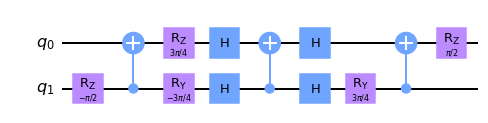

In [37]:
gate_Hxx = get_Hxxx_circuit(t, normal_three_cnot)
qc = QuantumCircuit(2)
qc.append(gate_Hxx, [0, 1])
qc.decompose().draw("mpl")

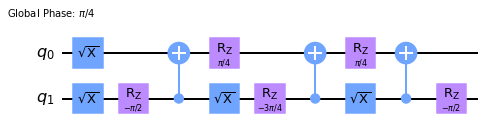

In [38]:
gate_Hxx = get_Hxxx_circuit(t, qiskit_kak)
qc = QuantumCircuit(2)
qc.append(gate_Hxx, [0, 1])
qc.decompose().draw("mpl")

* Circuit run with normal 3 CNOT decomposition
* if you want to run it on real device jakarta, replace NOISY_SIM with JAKARTA

In [39]:
!python run_circuit.py backend_name=NOISY_SIM trotter.unit_qc.qr13.key=NORMAL trotter.unit_qc.qr35.key=NORMAL

/home/jovyan/work/run_circuit.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
[2022-04-24 03:39:20,604][__main__][INFO] - Start job submission...
[2022-04-24 03:39:26,053][src.run_mode_definitions][INFO] - backend: BackendName.NOISY_SIM
[2022-04-24 03:39:26,053][src.carib][INFO] - Preparing measurement caribration on qr:[1, 3, 5] ...
[2022-04-24 03:39:26,059][src.trotter_steps][INFO] - Decomposed unit trotter_step, 
                   ┌───┐┌───────────┐ ┌───┐┌───┐┌───┐             ┌───┐»
q2_0: ────────────┤ X ├┤ Rz(7π/10) ├─┤ H ├┤ X ├┤ H ├─────────────┤ X ├»
      ┌──────────┐└─┬─┘├───────────┴┐├───┤└─┬─┘├───┤┌───────────┐└─┬─┘»
q2_1: ┤ Rz(-π/2) ├──■──┤ Ry(-7π/10) ├┤ H ├──■──┤ H ├┤ Ry(7π/10) ├──■──»
      ├──────────┤   

* Circuit run with qiskit kak decomposition

In [40]:
!python run_circuit.py backend_name=NOISY_SIM trotter.unit_qc.qr13.key=QISKIT_KAK trotter.unit_qc.qr35.key=QISKIT_KAK

/home/jovyan/work/run_circuit.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
[2022-04-24 03:40:20,580][__main__][INFO] - Start job submission...
[2022-04-24 03:40:25,993][src.run_mode_definitions][INFO] - backend: BackendName.NOISY_SIM
[2022-04-24 03:40:25,993][src.carib][INFO] - Preparing measurement caribration on qr:[1, 3, 5] ...
[2022-04-24 03:40:26,010][src.trotter_steps][INFO] - Decomposed unit trotter_step, 
 global phase: π/2
      ┌────┐            ┌───┐┌─────────┐              ┌───┐┌─────────┐┌───┐»
q2_0: ┤ √X ├────────────┤ X ├┤ Rz(π/5) ├──────────────┤ X ├┤ Rz(π/5) ├┤ X ├»
      ├────┤┌──────────┐└─┬─┘└──┬────┬─┘┌────────────┐└─┬─┘└──┬────┬─┘└─┬─┘»
q2_1: ┤ √X ├┤ Rz(-π/2) ├──■─────┤ √X ├──┤ Rz(-7π/10) ├──■───